In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# file renamings
import os

# directory containing the files
directory = 'C:\\Users\\advai\\College Semesters\\22-23 Win\\data-driven analysis of LCK\\Testing'

# iterate over the files in the directory
for filename in os.listdir(directory):
    # check if filename ends with 'Player Stats - OraclesElixir.csv'
    if filename.endswith(' - Player Stats - OraclesElixir.csv'):
        # remove 'Player Stats - OraclesElixir' from filename and keep the rest
        new_filename = filename.replace(' - Player Stats - OraclesElixir', '').strip()
        # construct the full path to the file
        filepath = os.path.join(directory, filename)
        new_filepath = os.path.join(directory, new_filename)
        # rename the file
        os.rename(filepath, new_filepath)


In [4]:
split_data = ["LCK 2022 Spring.csv", "LCK 2022 Summer.csv", "LCK 2021 Spring.csv", "LCK 2021 Summer.csv",
              "LCK 2020 Spring.csv", "LCK 2020 Summer.csv", "LCK 2019 Spring.csv", "LCK 2019 Summer.csv",
              "LCK 2018 Spring.csv", "LCK 2018 Summer.csv", "LCK 2017 Spring.csv", "LCK 2017 Summer.csv",
              "LCK 2016 Spring.csv", "LCK 2016 Summer.csv", "Champions 2015 Spring.csv", "Champions 2015 Summer.csv"]
mvp_data = ['2022_spring.csv', '2022_summer.csv', '2021_spring.csv', '2021_summer.csv',
            '2020_spring.csv', '2020_summer.csv', '2019_spring.csv', '2019_summer.csv',
            '2018_spring.csv', '2018_summer.csv', '2017_spring.csv', '2017_summer.csv',
            '2016_spring.csv', '2016_summer.csv', '2015_spring.csv', '2015_summer.csv']

splits = []

In [5]:
temp = pd.read_csv("LCK 2016 Spring.csv")
print(temp.columns)
emPlayers = temp[temp['Team'] == 'e-mFire']
kdPlayers = temp[temp['Team'] == 'Kongdoo Monster']
for player in emPlayers['Player']:
            # get the GP (games played) when in either team
            em_data = emPlayers[emPlayers['Player'] == player].iloc[0]
            kd_data = kdPlayers[kdPlayers['Player'] == player].iloc[0]
            # print(em_data)


Index(['Player', 'Team', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'STL', 'WPM', 'CWPM', 'WCPM'],
      dtype='object')


In [6]:
from statistics import mean

for index in range(0, len(split_data)):
    split = pd.read_csv(split_data[index])
    
    # filter out players with less than 10 games
    split = split[split['GP'] >= 10]
    
    # add a year and season indicator to each player data
    split['Year'] = str(split_data[index][4:8])
    split['Season'] = split_data[index][9:15]
    
    # special case where ShowMaker (the absolute monster) played ADC (10 games) (Ghost got benched)
    # and many more Mid in DWG for '21 Spring
    # his Pog points are counted the same, but he is represented as two separate roles
    # we take the decision to remove ShowMaker ADC from the list
    # when ShowMaker played ADC, his jungler Canyon filled into mid. During this time,
    # Malrang was trying out for the jungle role. He eventually left to join KOI (then Rogue) 
    # in the LEC region 
    if split['Year'].iloc[0] == '2021' and split['Season'].iloc[0] == 'Summer':
        #print(split.shape)
        split = split[~((split['Player'] == 'ShowMaker') & (split['Pos'] == 'ADC'))]
        split = split[~((split['Player'] == 'Canyon') & (split['Pos'] == 'Middle'))]
        #print(split.shape)
    
    exclude = ['Player', 'Team', 'Pos', 'Year', 'Season']
    incldue = [col for col in split.columns if col not in exclude]
    for cols in incldue:
        for idx, val in split[cols].items():
            if str(val).endswith("%"):
                split.at[idx, cols] = str(val.strip("%"))

    split[incldue] = split[incldue].astype('float64')
    
    # another special case - in 2016 Spring, emFire renamed to Kongdoo Monster
    # this causes the players to have double entries for their names 
    if split['Year'].iloc[0] == '2016' and split['Season'].iloc[0] == 'Spring':
        # the team renamed
        emPlayers = split[split['Team'] == 'e-mFire']
        kdPlayers = split[split['Team'] == 'Kongdoo Monster']
        
        # columns are ['Player', 'Team', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
        # 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
        # 'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'STL', 'WPM', 'CWPM', 'WCPM']
        for player in emPlayers['Player']:
            # get the GP (games played) when in either team
            em_data = emPlayers[emPlayers['Player'] == player].iloc[0]
            kd_data = kdPlayers[kdPlayers['Player'] == player].iloc[0]
            
            gp1 = em_data['GP'] # games played while in e-mFire
            gp2 = kd_data['GP'] # games played while in Kongdoo Monster
            # for the column Player, use the same player name
            # for the column Team, use the value 'e-mFire_Kongdoo Monster'
            # for the column Pos, use the same value as in emPlayers
            # for the column GP, add the value of gp1 and gp2
            # for the columns K, D, A add the corresponding column values from emPlayers and kdPlayers
            # for the other columns, take the average of the corresponding columns (they are already avg)
            newRow = pd.DataFrame(columns=split.columns)
            newRow['Player'] = player
            newRow['Team'] = 'e-mFire_Kongdoo Monster'
            newRow['Pos'] = em_data['Pos']
            newRow['Year'] = em_data['Year']
            newRow['Season'] = em_data['Season']
            newRow['GP'] = em_data['GP'] + kd_data['GP']
            for col in incldue:
                if col != 'GP':
                    newRow[col] = mean([em_data[col], kd_data[col]])
            split.append(newRow)
        # remove the playes with the 'Team' as 'e-mFire' or 'Kongdoo Monster'
        split = split[~split['Team'].isin(['e-mFire', 'Kongdoo Monster'])]
    
    split = split.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvp_cur = pd.read_csv(mvp_data[index])
    mvp_cur = mvp_cur.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvplist = mvp_cur['MVP'].reset_index(drop=True)
    split = split.reset_index(drop=True)
    split['MVP'] = mvplist
    splits.append(split)
    

In [7]:
from sklearn.preprocessing import MinMaxScaler
def scale_split(df):
    scaler = MinMaxScaler()
    numerical_columns = df.select_dtypes(include='number').columns
    #print(numerical_columns)
    scaled_df = df.copy()
    
    scaled_df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    non_numeric_columns = df.select_dtypes(exclude='number').columns
    #print(non_numeric_columns)
    scaled_df[non_numeric_columns] = df[non_numeric_columns]
    
    return scaled_df

In [8]:
scaled_splits = []
for split in splits:
    scaled = scale_split(split)
    scaled_splits.append(scaled)
whole_set = pd.concat(scaled_splits, ignore_index=True)

In [9]:
narows = whole_set[whole_set['MVP'].isnull()]
print(narows)
# no rows have NA values for MVP, values have been properly filled

Empty DataFrame
Columns: [Player, Team, Pos, GP, W%, CTR%, K, D, A, KDA, KP, KS%, DTH%, FB%, GD10, XPD10, CSD10, CSPM, CS%P15, DPM, DMG%, D%P15, EGPM, GOLD%, STL, WPM, CWPM, WCPM, Year, Season, MVP]
Index: []

[0 rows x 31 columns]


In [10]:
#<Note: shift the copying over of MVP from main code to side code>

In [11]:
#whole_set[['Player', 'MVP']].sort_values(by='MVP', ascending=False).head(5)
whole_set = whole_set.dropna(axis=1)
whole_set_vals = whole_set.select_dtypes(include='number')
whole_set_vals = whole_set_vals.drop(['GP', 'MVP'], axis=1)
whole_set_labels = whole_set.select_dtypes(exclude='number')
whole_set_labels = pd.concat([whole_set_labels, whole_set[['GP', 'MVP']]], axis=1)

# drop the columns 
# games played (represented as 'GP') (More games played = more chances to receive MVP, not a great indicator)
# MVP (represented as 'MVP') (What we want to use a ranking/class/predictor)
# from the list whole_set
role_sets = []
role_sets_labels = []
role_sets_vals = []

In [12]:
positions = list(set(whole_set_labels['Pos']))

# generating 5 sets of data for players in each role
for position in positions:
    role_sets.append(whole_set[whole_set['Pos'] == position])
    role_sets_labels.append(whole_set_labels[whole_set_labels['Pos'] == position])
    role_sets_vals.append(whole_set_vals[whole_set_labels['Pos'] == position])

In [13]:
role_sets[positions.index("ADC")].sort_values(by='KDA', ascending=False).head()

,Player,Team,Pos,GP,W%,K,D,A,KDA,KP,...,DPM,DMG%,EGPM,GOLD%,WPM,CWPM,WCPM,Year,Season,MVP
283,Teddy,T1,ADC,0.941176,0.901961,0.932990,0.291667,0.420213,1.0,0.740351,...,0.878676,0.920139,1.000000,0.955752,0.095890,0.096154,0.421053,2020,Spring,0.583333
224,Teddy,T1,ADC,0.236842,0.685185,0.312849,0.081481,0.196262,1.0,0.696498,...,0.942553,0.897638,0.875000,0.868020,0.377483,0.157895,0.775000,2021,Summer,0.272727
462,Viper,Griffin,ADC,0.888889,0.932432,0.982456,0.169643,0.456338,1.0,0.833992,...,0.898678,0.937500,1.000000,0.884615,0.071429,0.000000,0.620000,2019,Summer,0.700000
519,Bang,SK Telecom T1,ADC,1.000000,0.530864,0.792683,0.231481,0.554386,1.0,0.784512,...,0.962264,0.982993,0.919283,0.885417,0.123457,0.129630,0.307692,2018,Spring,0.727273
628,Bang,SK Telecom T1,ADC,0.857143,0.980769,0.671958,0.231405,0.601227,1.0,0.341463,...,1.000000,0.877358,0.940541,0.807947,0.093023,0.024390,0.157895,2017,Spring,0.307692


We test a hypothesis that within a given role, there are different playstyles and players can be categorized into one of few. We use KMeans clustering to first divide players into anywhere from 2 to 9 clusters, and then take the silhouette score of the given arrangement of clusters for the particular role

We then show the best clustering result based on the silhouette score, and accept the hypothesis if it is significant. Silhouette score ranges from -1 to +1, and is a measure of how similar a given player is to other players in their assigned cluster, vs other players in different clusters.

We place the threshold value for silhouette score at 0.6

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

predicted_labels = []
for role in positions:
    labels = []
    silhouettes = []
    max_silhouette = -1
    max_silhouette_cluster = None
    for num in range(2, 10):
        my_set = role_sets[positions.index(role)]
        my_set_vals = role_sets_vals[positions.index(role)]
        my_set_labels = role_sets_labels[positions.index(role)]
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(my_set_vals)
        labels.append(kmeans.labels_)
        silhouette_avg = silhouette_score(my_set_vals, labels[num-2])
        #print("Silhouette score for role", role , " at clusters", num, ": ", silhouette_avg)
        silhouettes.append(silhouette_avg)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            max_silhouette_cluster = kmeans.labels_
    print("Max silhouette score for role", role, "at clusters", silhouettes.index(max_silhouette) + 2, ": ", max_silhouette)
    predicted_labels.append(max_silhouette_cluster)
    

Max silhouette score for role ADC at clusters 2 :  0.2266611785473249
Max silhouette score for role Top at clusters 2 :  0.21300327941729816
Max silhouette score for role Jungle at clusters 2 :  0.16726698379317165
Max silhouette score for role Support at clusters 2 :  0.1790310539399344
Max silhouette score for role Middle at clusters 2 :  0.21065331478275875


Silhouettes scores are less than 0.3 across the board, suggesting that the available data is not enough to classify each role into different playstyles, or that there is no particular difference between player playstyles

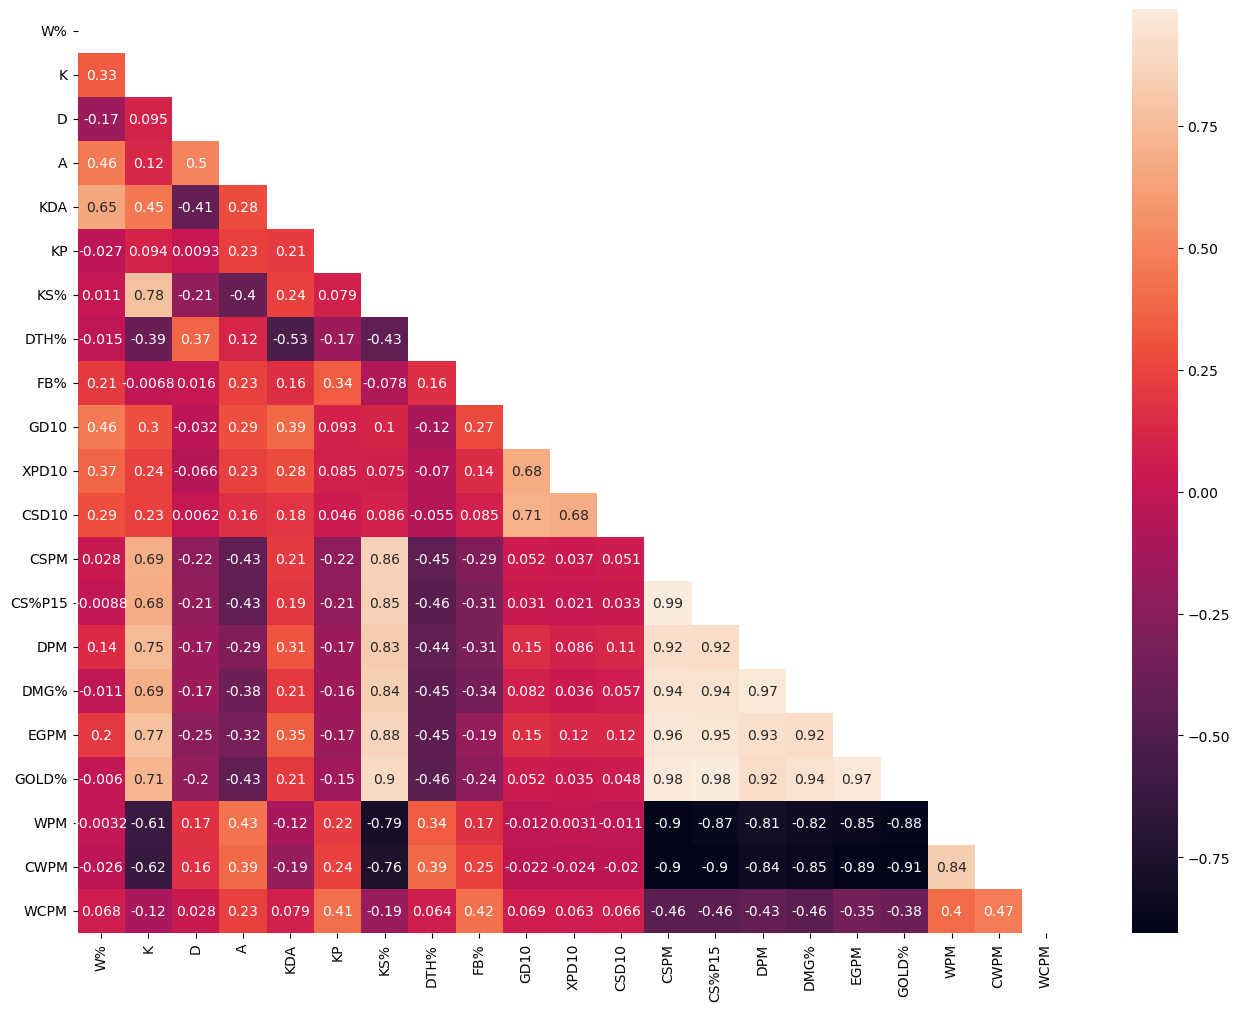

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(whole_set_vals.corr(), dtype=bool))

heatmap = sns.heatmap(whole_set_vals.corr(), mask=mask, annot=True)

plt.show()

As we can see, a lot of the features selected are features with insanely high correlation

Eg. CS%P15 and CSPM have a 0.98 corr, and GOLD% and EGPM also have a 0.98 corr

In [33]:
high_corr = whole_set_vals.corr().abs().mask(mask)
to_drop = [column for column in high_corr.columns if any(high_corr[column] > 0.9)]
print(to_drop)
refined_to_drop = ['CS%P15', 'EGPM', 'DPM']
#dropping the columns from the dataframe
new_vals = whole_set_vals.drop(columns=refined_to_drop)
new_set = whole_set.drop(columns=refined_to_drop)

['CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%']


In [43]:
new_role_sets = []
new_role_sets_labels = []
new_role_sets_vals = []

for position in positions:
    new_role_sets.append(new_set[whole_set['Pos'] == position])
    new_role_sets_vals.append(new_vals[whole_set_labels['Pos'] == position])

GOLD% is the player's gold as a %age of the team's total gold.

    Players who have higher Earned Gold Per Minute will also have higher GOLD%

    Similarly, higher Creep Score Per Minute also leads to earning higher GOLD

When you have higher GOLD%, you tend to have more items and thus deal more damage

    Therefore DPM and DMG% are also related.

Having higher Creep Share %age post 15 minutes is similarly a highly correlated factor

    With more damage, you tend to clear waves faster

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
role_vifs = []
for role in positions:
    vifs = pd.DataFrame()
    my_set = new_role_sets[positions.index(role)]
    my_set_vals = new_role_sets_vals[positions.index(role)]
    #my_set_labels = role_sets_labels[positions.index(role)]
    vifs['features'] = my_set_vals.columns
    vifs['VIF'] = [variance_inflation_factor(my_set_vals.values, i)
                            for i in range(len(my_set_vals.columns))]
    role_vifs.append(vifs)

In [36]:
for role in positions:
    vifs = role_vifs[positions.index(role)]
    print("VIFs for Role :", role)
    print(vifs.sort_values(by='VIF', ascending=False).head())
# shows us that gold%, egpm, etc are highly dependant on other stats.
# eg. gold% is from higher cspm, higher kills, higher gd@10, etc.

VIFs for Role : ADC
   features         VIF
14    GOLD%  871.525326
12     CSPM  602.618237
6       KS%  204.910778
13     DMG%  154.266097
1         K   85.066321
VIFs for Role : Top
   features         VIF
14    GOLD%  615.448353
12     CSPM  527.426278
6       KS%   78.402633
13     DMG%   72.551894
1         K   46.406564
VIFs for Role : Jungle
   features        VIF
14    GOLD%  97.036786
12     CSPM  70.763878
6       KS%  58.279790
1         K  40.188064
3         A  34.712677
VIFs for Role : Support
   features        VIF
15      WPM  93.377397
16     CWPM  61.949198
3         A  48.526391
11    CSD10  26.544591
9      GD10  25.720742
VIFs for Role : Middle
   features         VIF
14    GOLD%  713.584529
12     CSPM  652.472409
6       KS%  140.955007
13     DMG%   97.295685
1         K   57.535263


We now test the hypothesis that any given role is measureably different from another role. We test it visually using PCA and a simple plot, spectral clustering, and with label matching using xgBoost.

A simple PCA 2dim plot can give a good baseline

Spectral clustering is good for identifying clusters in high-deminsional data

xgBoost is capable and fast, and handles complex non-linear relationships, selection of important features, and regularization to prevent overfitting

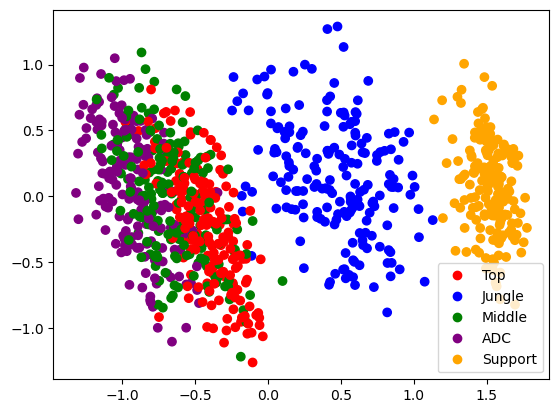

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(whole_set_vals)

label_color_map = {
    'Top': 'red',
    'Jungle': 'blue',
    'Middle': 'green',
    'ADC': 'purple',
    'Support': 'orange'
}

colors = np.array([label_color_map[label] for label in whole_set_labels['Pos']])


fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, 
                     label=whole_set_labels['Pos'])

# Add labels to the points
#for i, txt in enumerate(larger_dataset_labels['Pos']):
#    ax.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, 
                              label=label, linestyle='') for label, color in label_color_map.items()]
ax.legend(handles=legend_elements, loc='best')

plt.show()

We can visually see with the 2dim PCA plot, that the Support and Jungle role are clearly different from the Mid, Top, and ADC roles

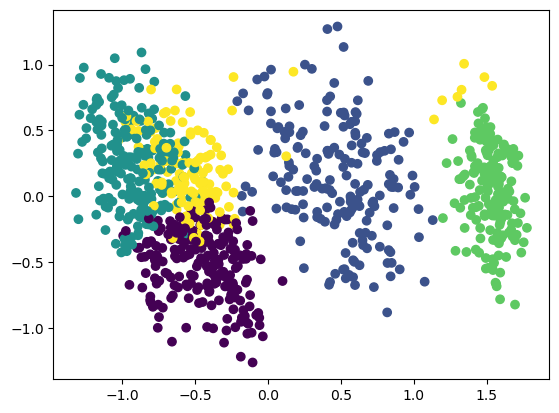

In [20]:
from sklearn.cluster import SpectralClustering

# Perform PCA with 5 components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(whole_set_vals)

# Apply spectral clustering to the transformed data
spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42)
spectral_labels = spectral.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels)
plt.show()

Spectral Clustering does not seem to be able to properly place the players into their respective positions

This might suggest that there is some correlation between different roles

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
pos_encoded = label_encoder.fit_transform(whole_set_labels['Pos'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_vals, pos_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy (in predicting Pos): %.2f%% (with un-PCA\'d features)' % (accuracy * 100.0))


Accuracy (in predicting Pos): 90.61% (with un-PCA'd features)


In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, pos_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%% (with PCA\'d features)' % (accuracy * 100.0))

Accuracy: 73.48% (with PCA'd features)


xgBoost provides a <#to fill> accuracy on the given data in classifying players into their respective positions based on data. Using PCA cuts it down to <#to fill>.

This seems to strongly suggest that there is a clear cut difference between various roles

In [42]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
rfe.fit(new_vals, whole_set_labels['MVP'])

print(new_vals.columns[rfe.support_])

Index(['W%', 'K', 'A', 'DTH%', 'FB%', 'GD10', 'CSD10', 'DMG%', 'GOLD%', 'WPM'], dtype='object')


In [47]:
common_features = None
common_three = None
common_four = None

for role in positions:
    my_set_labels = role_sets_labels[positions.index(role)]
    my_set_vals = new_role_sets_vals[positions.index(role)]
    rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
    rfe.fit(my_set_vals, my_set_labels['MVP'])
    
    print("for role :", role)
    print(my_set_vals.columns[rfe.support_], "\n")
    
    if common_features is None:
        common_features = set(my_set_vals.columns[rfe.support_])
    else:
        common_features = common_features.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top']:
        if common_three is None:
            common_three = set(my_set_vals.columns[rfe.support_])
        else:
            common_three = common_three.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top', 'Jungle']:
        if common_four is None:
            common_four = set(my_set_vals.columns[rfe.support_])
        else:
            common_four = common_four.intersection(set(my_set_vals.columns[rfe.support_]))
        
print("Common features across all roles:", common_features)
print("Common across ADC, Mid, Top", common_three)
print("Common across above three and Jungle", common_four)

for role : ADC
Index(['K', 'D', 'A', 'KP', 'CSD10', 'DMG%', 'GOLD%', 'WPM', 'CWPM', 'WCPM'], dtype='object') 

for role : Top
Index(['K', 'A', 'KDA', 'KP', 'KS%', 'GD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM'], dtype='object') 

for role : Jungle
Index(['W%', 'K', 'D', 'KDA', 'KP', 'KS%', 'GD10', 'CSPM', 'DMG%', 'WPM'], dtype='object') 

for role : Support
Index(['W%', 'D', 'A', 'KDA', 'DTH%', 'FB%', 'CSPM', 'DMG%', 'GOLD%', 'CWPM'], dtype='object') 

for role : Middle
Index(['W%', 'K', 'A', 'KS%', 'DTH%', 'GD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM'], dtype='object') 

Common features across all roles: {'DMG%'}
Common across ADC, Mid, Top {'DMG%', 'K', 'WPM', 'A', 'GOLD%', 'KP'}
Common across above three and Jungle {'DMG%', 'K', 'KP', 'WPM'}


Now with this information, lets develop a ranking system to assign the MVP points players